<a href="https://colab.research.google.com/github/rondinell/Intelig-ncia-Artificial/blob/main/C%C3%B3pia_de_meuconsultordepre%C3%A7osFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install yfinance ta scikit-learn tensorflow
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=60c3d677acd85f6d5dab3529723c6da19c4f8d182b2e9d15be69fe3df45e9d07
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [6]:
# Baixar os dados dos últimos 5 anos DO ATIVO ESCOLHIDO
ativo = "VCRA11.SA"
data_inicio = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')
data_fim = datetime.today().strftime('%Y-%m-%d')
dados = yf.download(ativo, start=data_inicio, end=data_fim)


<ipython-input-6-1598620938>:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(ativo, start=data_inicio, end=data_fim)
[*********************100%***********************]  1 of 1 completed


In [7]:
# Normalizar os preços de fechamento
scaler = MinMaxScaler(feature_range=(0, 1))
dados['Close'] = scaler.fit_transform(dados['Close'].values.reshape(-1, 1))

In [8]:
# Criar sequências de 182 dias para prever o próximo preço
def criar_dados(dados, janela=182):
    X, y = [], []
    for i in range(janela, len(dados)):
        X.append(dados[i-janela:i])
        y.append(dados[i])
    return np.array(X), np.array(y)

X, y = criar_dados(dados['Close'].values)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [9]:
# Criar modelo LSTM
modelo = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Compilar o modelo
modelo.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Treinar o modelo
# Para analise
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, validation_data=(X_teste, y_teste))


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1703 - val_loss: 0.0104
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - loss: 0.0167 - val_loss: 0.0071
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0132 - val_loss: 0.0061
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - loss: 0.0105 - val_loss: 0.0055
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - loss: 0.0100 - val_loss: 0.0056
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.0083 - val_loss: 0.0055
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.0099 - val_loss: 0.0047
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step

In [12]:
# Prever os próximos 20 dias
dados_finais = dados['Close'].values[-60:].reshape(1, -1, 1)
previsoes = []
for _ in range(20):
    previsao = modelo.predict(dados_finais)
    previsoes.append(previsao[0][0])
    # The previsao has shape (1,1) but we need (1,1,1)
    # Use reshape to add the extra dimension
    dados_finais = np.append(dados_finais[:,1:,:], previsao.reshape(1,1,1), axis=1)# Prever os próximos 7 dias
dados_finais = dados['Close'].values[-60:].reshape(1, -1, 1)
previsoes = []
for _ in range(20):
    previsao = modelo.predict(dados_finais)
    previsoes.append(previsao[0][0])
    # The previsao has shape (1,1) but we need (1,1,1)
    # Use reshape to add the extra dimension
    dados_finais = np.append(dados_finais[:,1:,:], previsao.reshape(1,1,1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

In [13]:
# Converter previsões de volta ao preço real
previsoes = scaler.inverse_transform(np.array(previsoes).reshape(-1, 1))

In [14]:
# Exibir previsões
print("Previsões para a próximos 20 dias no preço de compra:")
for i, valor in enumerate(previsoes):
    print(f"Dia {i+1}: R$ {valor[0]:.2f}")


Previsões para a próximos 20 dias no preço de compra:
Dia 1: R$ 64.06
Dia 2: R$ 64.01
Dia 3: R$ 63.92
Dia 4: R$ 63.79
Dia 5: R$ 63.64
Dia 6: R$ 63.48
Dia 7: R$ 63.31
Dia 8: R$ 63.13
Dia 9: R$ 62.95
Dia 10: R$ 62.78
Dia 11: R$ 62.62
Dia 12: R$ 62.46
Dia 13: R$ 62.32
Dia 14: R$ 62.18
Dia 15: R$ 62.05
Dia 16: R$ 61.93
Dia 17: R$ 61.82
Dia 18: R$ 61.72
Dia 19: R$ 61.62
Dia 20: R$ 61.53


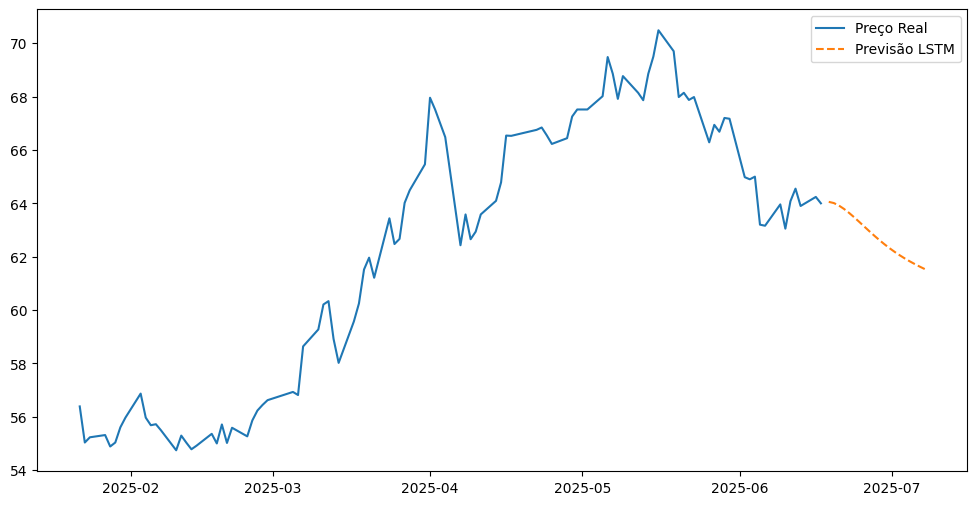

In [15]:
# Plotar os resultados
plt.figure(figsize=(12,6))
plt.plot(dados.index[-100:], scaler.inverse_transform(dados['Close'].values[-100:].reshape(-1,1)), label="Preço Real")
# Adjust the periods to match the length of 'previsoes'
plt.plot(pd.date_range(start=datetime.today(), periods=len(previsoes)), previsoes, label="Previsão LSTM", linestyle='dashed')
plt.legend()
plt.show()

In [16]:
import numpy as np
import yfinance as yf # Import yfinance to fetch dividend data

# ... (rest of your code) ...

# Obter o último preço previsto
ultimo_preco_previsto = previsoes[-1][0]

# Obter preço atual real (desnormalizado)
preco_atual = scaler.inverse_transform(np.array(dados['Close'].iloc[-1]).reshape(-1,1))[0][0]

# Definir limite de compra (ex: 5% abaixo da previsão)
limite_compra = 1.00 * ultimo_preco_previsto

# Fetch dividend data using yfinance
ativo = "VCRA11.SA"  # Use the same asset as before
dividendos = yf.Ticker(ativo).dividends  # Get dividend data

# Check if 'Dividends' is in the info and use it if available
if 'Dividends' in yf.Ticker(ativo).info and yf.Ticker(ativo).info['Dividends'] > 0:
    dividendos_anuais = yf.Ticker(ativo).info['Dividends']
# Ensure dividend data is not empty before proceeding
elif not dividendos.empty:
    # Access the dividend values using the index (dates)
    dividendos_anuais = dividendos.sum()
else:
    print("⚠️ Dividend data is empty or not available. Using a default value for dividend yield calculation.")
    dividendos_anuais = 0  # Set to 0 or a default value if data is empty

# Calcular Dividend Yield (%)
dividend_yield = (dividendos_anuais / preco_atual) * 100

# Definir mínimo desejado de DY para considerar compra (ex: 6%)
dy_minimo = 6.0

# Decisão de compra considerando preço e dividendos
if preco_atual < limite_compra and dividend_yield >= dy_minimo:
    print(f"✅ Comprar! Preço atual R$ {preco_atual:.2f} abaixo do limite R$ {limite_compra:.2f} e DY = {dividend_yield:.2f}% >= {dy_minimo}%")
elif dividend_yield < dy_minimo:
    print(f"⚠️ Não comprar. DY = {dividend_yield:.2f}% está abaixo do mínimo de {dy_minimo}%")
else:
    print(f"⛔ Não comprar. Preço atual R$ {preco_atual:.2f} acima do limite R$ {limite_compra:.2f}")

⛔ Não comprar. Preço atual R$ 64.00 acima do limite R$ 61.53
